# Домашнее задание к занятию 2.1: Деревья решений. Классификация

## Обзор прошедшего занятия

Что мы делали в классе:

**Задание 1**
* строили деревья
* критерии информативности которых написали даже сами
* визуализировали границы принятия решений в 2d
* и рисовали сами деревья


**Задание 2**
* приняли участие в соревновании на Kaggle, переварив кучу текстовых фичей в численные, проведя кросс-валидацию и сделав сабмит


**Задание 3**
* построили руками несколько метрик качества бинарной классификации


**Задание 4**
* использовали их для оценки классификации разделения статей Ведомостей по топикам

*дополнительно было много приятных ништяков. Например, облако слов, мультипоточность в целях парсинга, удобный инструмент для нахождения правильной css разметки, сохранение моделей в статичные файлы, разделение строк на слова и лемматизация этих слов*

## Домашнее задание

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

**Lvl 2:** (опционально)

* С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC
* Придумать себе интересную задачу на основе данных из интернета =) Спарсить ещё какой-нибудь сайт (не Ведомости) и решить задачу классификации. Делать свои проекты - круто. Если будут - кидайте мне =) [@NikitaKuznetsov](http://t.me/NikitaKuznesov)

In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)

### Данные

In [3]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

In [4]:
trg = 'Survived'

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


3 признака имеют пропущенные значения. Причем признак 'Cabin' имеет всего 204 ненулевых значения из 889 для обучающего набора, поэтому его можно удалить. Пропущенные значения возраста - можно заполнить средними значениями. 'Embarked' имеет всего 2 пропущенных значения. Также есть 1 пропущенное значение в тестовом наборе для признака 'Fare'.

In [9]:
# пропущенные значения 'Embarked'
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Оба образца имеют значение целевой переменной '1', поэтому не будем их удалять.

Посмотрим были ли еще билеты с таким же или близким номером (13752).

In [10]:
# извлечем цифровую часть билета
train['Ticket_num'] = train['Ticket'].str.split().apply(
    lambda x: [i if i.isdigit() else 0 for i in x][-1]).astype(int)

In [11]:
# найдем наиболее близкие по номеру билеты
ids_with_close_num = np.abs(train['Ticket_num'] - 113572).sort_values().head().index
ids_with_close_num

Int64Index([61, 829, 252, 351, 54], dtype='int64')

In [12]:
train[['Ticket', 'Embarked', 'Fare']].loc[ids_with_close_num].head()

,Ticket,Embarked,Fare
61,113572,NaN,80.0000
829,113572,NaN,80.0000
252,113514,S,26.5500
351,113510,S,35.0000
54,113509,C,61.9792


In [13]:
train['Embarked'].value_counts(normalize=True)

S    0.724409
C    0.188976
Q    0.086614
Name: Embarked, dtype: float64

К сожалениею, таких же или близких билетов нет, поэтому заполним пропущенные значения самым распространенным значением для признака 'Embarked' - 'S'

In [14]:
train['Embarked'].fillna('S', inplace=True)

In [15]:
# распределение целевой переменной
train['Survived'].value_counts(normalize=True)*100

0    61.616162
1    38.383838
Name: Survived, dtype: float64

In [16]:
# пропущенные значения 'Embarked'
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [17]:
test['Fare'].fillna(train['Fare'].median(), inplace=True)

In [18]:
y_train = train[trg]

Прежде, чем удалять признак 'Ticket_num' интереса ради проверим, существуют ли счастливые билеты.

In [19]:
def lucky_num(digit):
    '''
    Функция возвращает 1, если сумма первой половины
    числа равна сумме второй половине числа (счастливый билет).
    '''
    length = len(str(digit))
    if length%2==0 and length>2:
        return int(sum(int(x) for x in str(digit)[:length//2])==
                sum(int(x) for x in str(digit)[length//2:]))
    elif length%2==1 and length>2:
        return int(sum(int(x) for x in str(digit)[:length//2+1])==
                sum(int(x) for x in str(digit)[length//2:]))
    else:
        return 0

In [20]:
train['lucky_num'] = train['Ticket_num'].apply(lucky_num)

In [21]:
len(train[(train[trg]==1) & (train['lucky_num']==1)])/\
        len(train[(train['lucky_num']==1)])

0.38181818181818183

Как видно шансы на выживание со счастливым билетом не отличаются от среднего шанса на выживание. Хотя, как гласит поверье, билет надо было съесть. В общем, нумерология не работает и признак 'Ticket_num' можно смело удалить.

Посмотрим, как влияли различные признаки на шанс выживания.

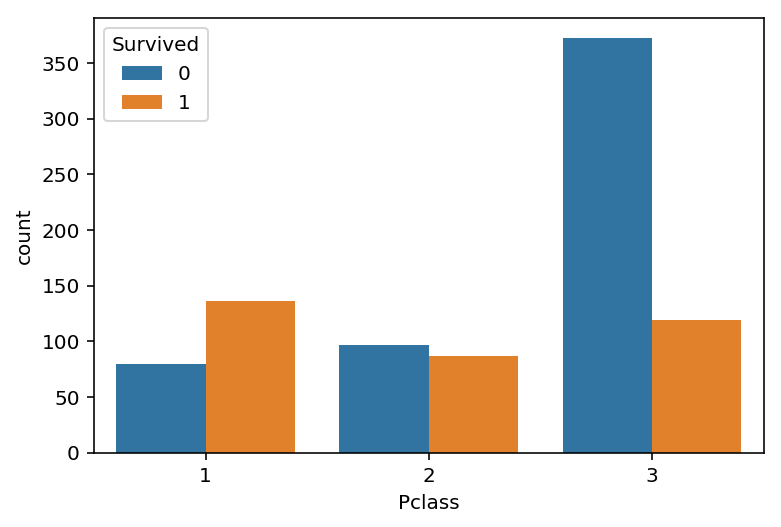

In [22]:
ax = sns.countplot(x = 'Pclass', hue = trg, data=train)

Класс сильно влиял на шанс выживания

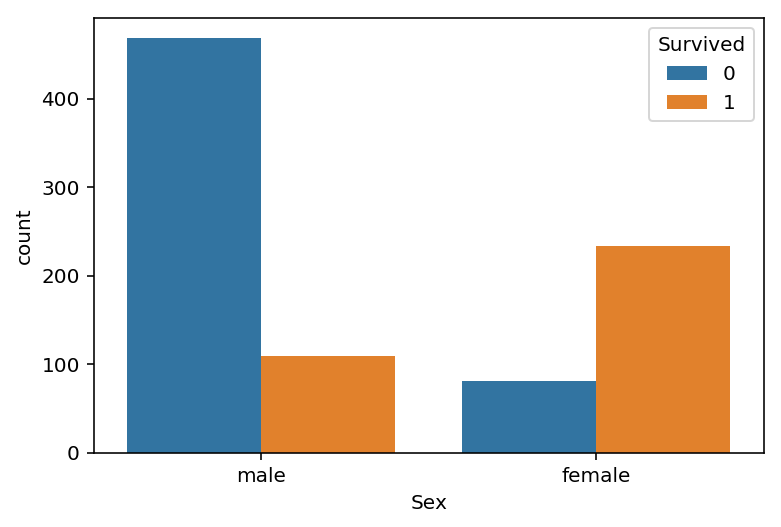

In [23]:
ax = sns.countplot(x = 'Sex', hue = trg, data=train)

Спасшихся женщин гораздо больше, чем мужчин

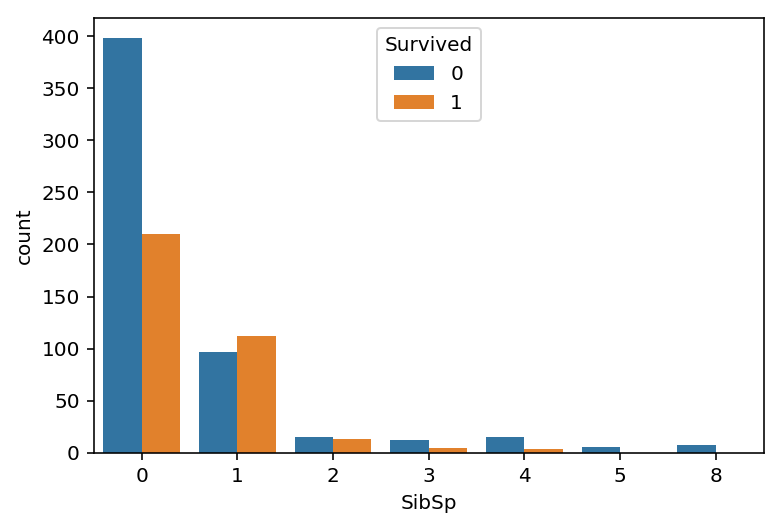

In [24]:
ax = sns.countplot(x = 'SibSp', hue = trg, data=train)

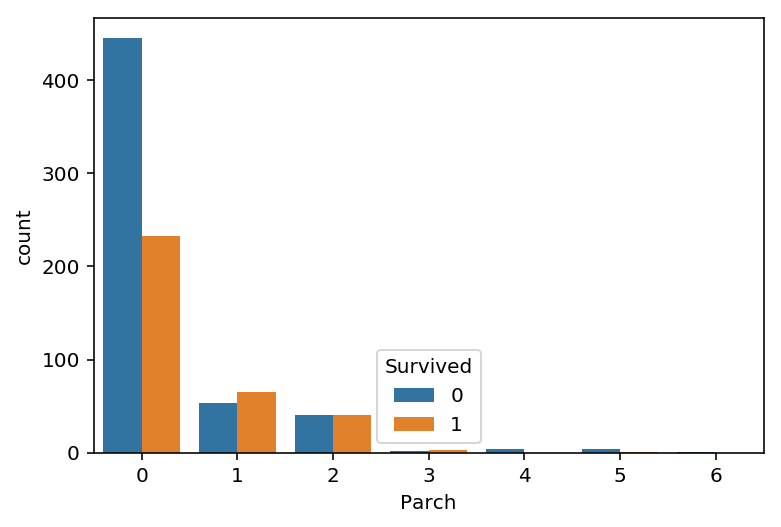

In [25]:
ax = sns.countplot(x = 'Parch', hue = trg, data=train)

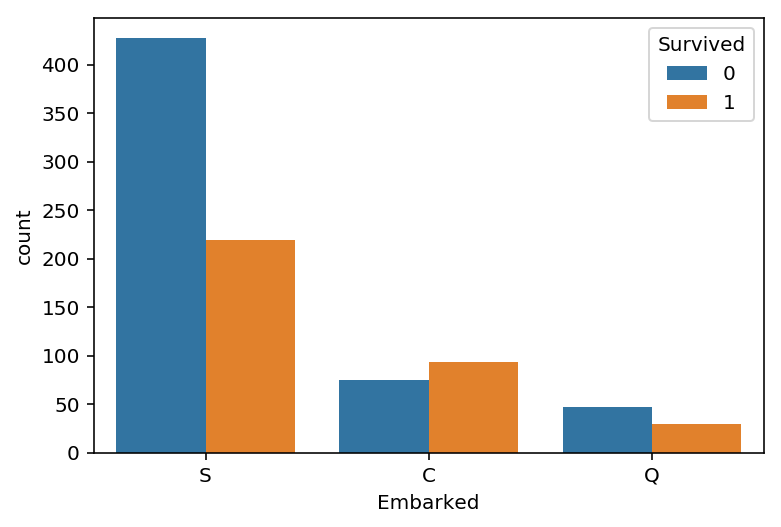

In [26]:
ax = sns.countplot(x = 'Embarked', hue = trg, data=train)

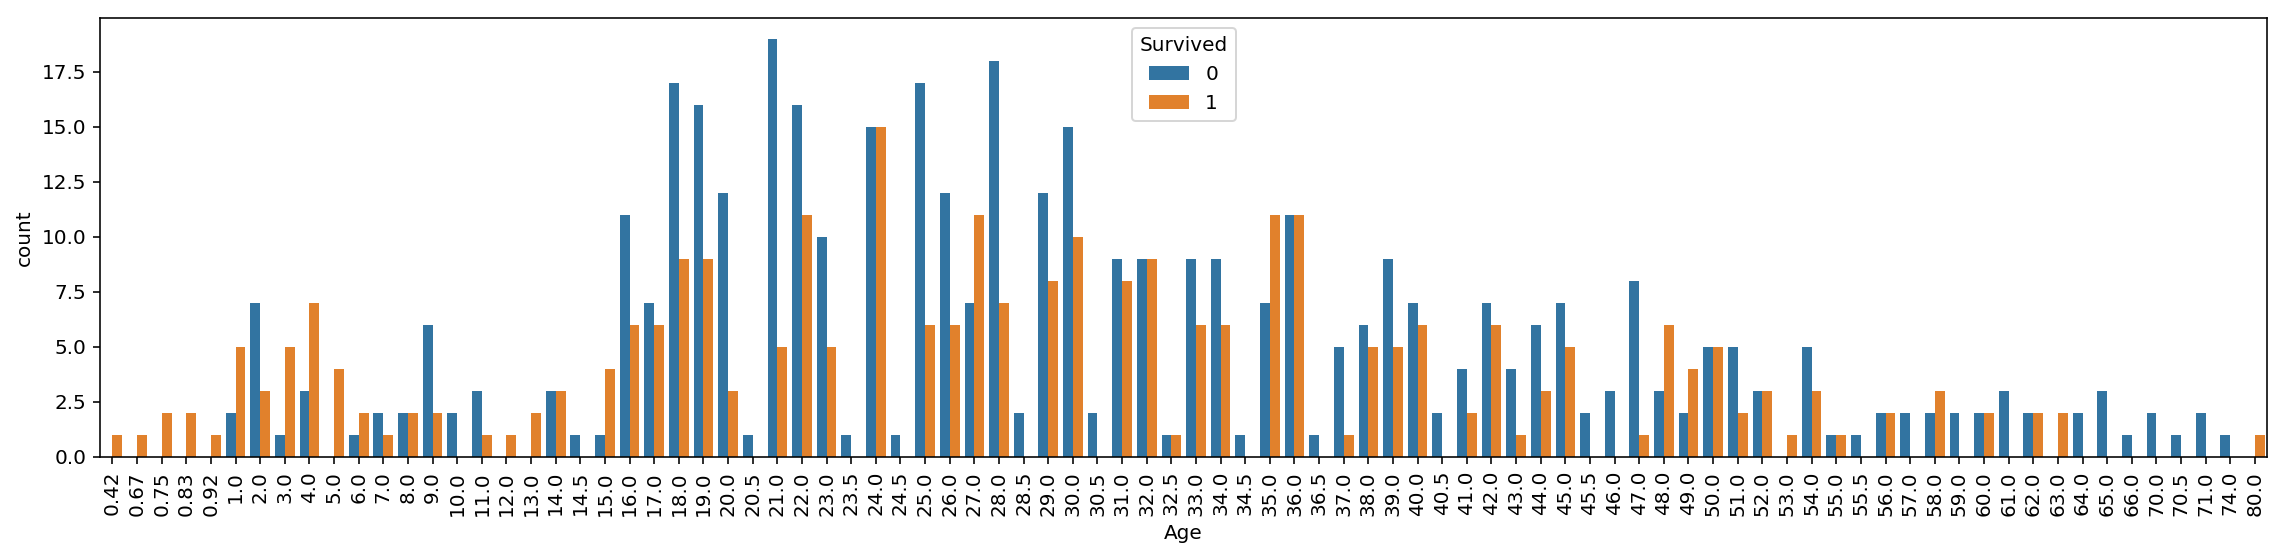

In [27]:
plt.figure(figsize=(16,4))
ax = sns.countplot(x = 'Age', hue = trg, data=train)
_ = plt.setp(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

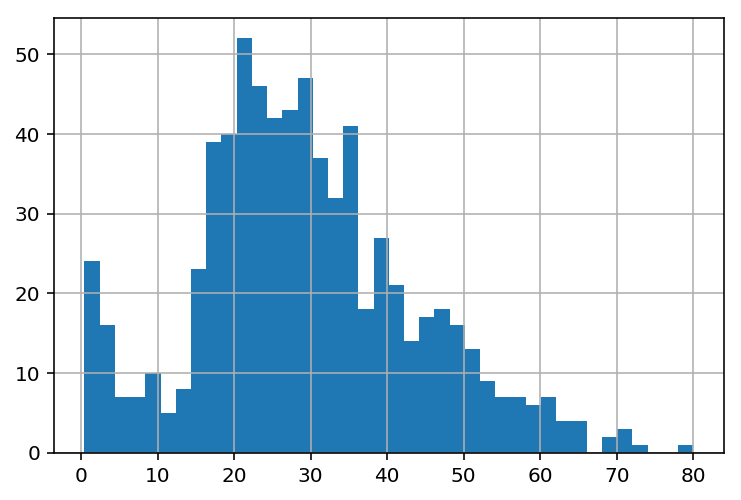

In [28]:
ax = train['Age'].hist(bins = 40)

In [29]:
train.drop(['Ticket_num', 'lucky_num'], axis=1, inplace=True)

In [30]:
test[trg] = 0
test_cols = test.columns.tolist()
test_cols = test_cols[0:1] + test_cols[-1:] + test_cols[1:-1]
test = test[test_cols]

In [31]:
all(train.columns == test.columns)

True

In [32]:
train['is_test'] = 0
test['is_test'] = 1

In [33]:
df = pd.concat([train, test])

In [34]:
df.set_index('PassengerId', inplace=True)

In [35]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_test
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [36]:
# преобразуем пол из категорий в бины.
df['isMale'] = df['Sex'].map({'male': 1, 'female': 0})

In [37]:
# выделим категорию - обращение из имени

In [38]:
all_names = sum(df['Name'].str.split(), [])
titles = [word for word in all_names if '.' in word]

In [39]:
from collections import Counter

In [40]:
titles_count = Counter(titles)
titles_count.most_common(10)

[('Mr.', 757),
 ('Miss.', 260),
 ('Mrs.', 197),
 ('Master.', 61),
 ('Rev.', 8),
 ('Dr.', 8),
 ('Col.', 4),
 ('Ms.', 2),
 ('Major.', 2),
 ('Mlle.', 2)]

In [41]:
# оставим только 4 самых распространенных обращения
final_titles = [title[0] for title in titles_count.most_common(6)]
final_titles

['Mr.', 'Miss.', 'Mrs.', 'Master.', 'Rev.', 'Dr.']

In [42]:
def extract_title(string, titles):
    for title in titles:
        if title in string:
            return title
    else:
        return 'no_title'

In [43]:
df['title'] = df['Name'].apply(extract_title, titles=final_titles)

In [44]:
df['title'].value_counts(dropna=False)

Mr.         757
Miss.       260
Mrs.        197
Master.      61
no_title     18
Rev.          8
Dr.           8
Name: title, dtype: int64

In [45]:
# удалим ненужные признаки
df.drop(['Name', 'Sex', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [46]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,is_test,isMale,title
PassengerId,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,S,0,1,Mr.
2,1,1,38.0,1,0,71.2833,C,0,0,Mrs.
3,1,3,26.0,0,0,7.9250,S,0,0,Miss.
4,1,1,35.0,1,0,53.1000,S,0,0,Mrs.
5,0,3,35.0,0,0,8.0500,S,0,1,Mr.


Заполним пропущенные значения возраста медианными значениями различных комбинаций категорильных данных. Для расчета медианы используется только обучающий набор.

In [47]:
median_age_1 = {}
for cl in df['Pclass'].unique():
        for title in df['title'].unique():
            median_age_1[cl, title] = df[(df['Pclass']==cl) & (df['title']==title) & (df['is_test']==0)]['Age'].median()

median_age_2 = {}
for cl in df['Pclass'].unique():
        for m  in df['isMale'].unique():
            median_age_2[cl, m] = df[(df['Pclass']==cl) & (df['isMale']==m) & (df['is_test']==0)]['Age'].median()

In [48]:
median_age_1

{(3, 'Mr.'): 26.0,
 (3, 'Mrs.'): 31.0,
 (3, 'Miss.'): 18.0,
 (3, 'Master.'): 4.0,
 (3, 'no_title'): nan,
 (3, 'Rev.'): nan,
 (3, 'Dr.'): nan,
 (1, 'Mr.'): 40.0,
 (1, 'Mrs.'): 41.5,
 (1, 'Miss.'): 30.0,
 (1, 'Master.'): 4.0,
 (1, 'no_title'): 45.0,
 (1, 'Rev.'): nan,
 (1, 'Dr.'): 46.5,
 (2, 'Mr.'): 31.0,
 (2, 'Mrs.'): 32.0,
 (2, 'Miss.'): 24.0,
 (2, 'Master.'): 1.0,
 (2, 'no_title'): 28.0,
 (2, 'Rev.'): 46.5,
 (2, 'Dr.'): 38.5}

In [49]:
median_age_2

{(3, 1): 25.0,
 (3, 0): 21.5,
 (1, 1): 40.0,
 (1, 0): 35.0,
 (2, 1): 30.0,
 (2, 0): 28.0}

In [50]:
def fill_age(row, med1=median_age_1, med2=median_age_2):
    title = row['title']
    cl = row['Pclass']
    age = row['Age']
    male = row['isMale']
    if pd.isnull(age) and not np.isnan(med1[row['Pclass'], row['title']]):
        return med1[row['Pclass'], row['title']]
    elif pd.isnull(age) and np.isnan(med1[row['Pclass'], row['title']]):
        return med2[row['Pclass'], row['isMale']]
    else:
        return age

In [51]:
df['Age'] = df[['Age', 'isMale', 'Pclass', 'title']].apply(fill_age, axis=1)

Преобразуем категории в OHE

In [52]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,is_test,isMale,title
PassengerId,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,S,0,1,Mr.
2,1,1,38.0,1,0,71.2833,C,0,0,Mrs.
3,1,3,26.0,0,0,7.9250,S,0,0,Miss.
4,1,1,35.0,1,0,53.1000,S,0,0,Mrs.
5,0,3,35.0,0,0,8.0500,S,0,1,Mr.


In [53]:
df_dummies = pd.get_dummies(data=df, columns=['Pclass', 'Embarked', 'title'])

In [54]:
df_dummies.head()

,Survived,Age,SibSp,Parch,Fare,is_test,isMale,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,title_Dr.,title_Master.,title_Miss.,title_Mr.,title_Mrs.,title_Rev.,title_no_title
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0
2,1,38.0,1,0,71.2833,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0
3,1,26.0,0,0,7.9250,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0
4,1,35.0,1,0,53.1000,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
5,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0


In [55]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 20 columns):
Survived          1309 non-null int64
Age               1309 non-null float64
SibSp             1309 non-null int64
Parch             1309 non-null int64
Fare              1309 non-null float64
is_test           1309 non-null int64
isMale            1309 non-null int64
Pclass_1          1309 non-null uint8
Pclass_2          1309 non-null uint8
Pclass_3          1309 non-null uint8
Embarked_C        1309 non-null uint8
Embarked_Q        1309 non-null uint8
Embarked_S        1309 non-null uint8
title_Dr.         1309 non-null uint8
title_Master.     1309 non-null uint8
title_Miss.       1309 non-null uint8
title_Mr.         1309 non-null uint8
title_Mrs.        1309 non-null uint8
title_Rev.        1309 non-null uint8
title_no_title    1309 non-null uint8
dtypes: float64(2), int64(5), uint8(13)
memory usage: 98.4 KB


In [56]:
X_train = df_dummies[df_dummies['is_test']==0].drop('is_test', axis=1)
X_test = df_dummies[df_dummies['is_test']==1].drop('is_test', axis=1)

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
np.random.seed(8)
X_train_fin, X_val, y_train_fin, y_val = train_test_split(
    X_train, y_train, stratify=X_train[[trg, 'Pclass_1', 'Pclass_2', 'Pclass_3', 'isMale']], test_size=0.1)

In [59]:
X_train_fin.drop(trg, axis=1, inplace=True)
X_val.drop(trg, axis=1, inplace=True)
X_train.drop(trg, axis=1, inplace=True)
X_test.drop(trg, axis=1, inplace=True)

/home/sergey/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [61]:
np.random.seed(8)
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X_train_fin, y_train_fin)

10

In [62]:
np.random.seed(8)
param_grid_dtc = {
        'max_depth': np.arange(3, 15),
        'max_features': ['sqrt', 'log2', None],
        'min_samples_leaf': np.arange(2, 10),
        'min_samples_split': np.arange(2, 10),
        }

grid_search_dtc = GridSearchCV(DecisionTreeClassifier(criterion='entropy', presort=True), 
        param_grid=param_grid_dtc, scoring='accuracy', cv=skf, return_train_score=True)

In [63]:
grid_search_dtc.fit(X_train_fin, y_train_fin)

/home/sergey/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=True, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), 'max_features': ['sqrt', 'log2', None], 'min_samples_leaf': array([2, 3, 4, 5, 6, 7, 8, 9]), 'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [64]:
grid_search_dtc.best_score_

0.8314606741573034

In [65]:
grid_search_dtc.cv_results_['mean_train_score'].shape

(2304,)

In [66]:
grid_search_dtc.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=True, random_state=None,
            splitter='best')

In [67]:
model = grid_search_dtc.best_estimator_

In [68]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [69]:
y_train_fin_predict = model.predict(X_train_fin)
y_val_predict = model.predict(X_val)

y_train_fin_prob = model.predict_proba(X_train_fin)[:, 1]
y_val_prob = model.predict_proba(X_val)[:, 1]

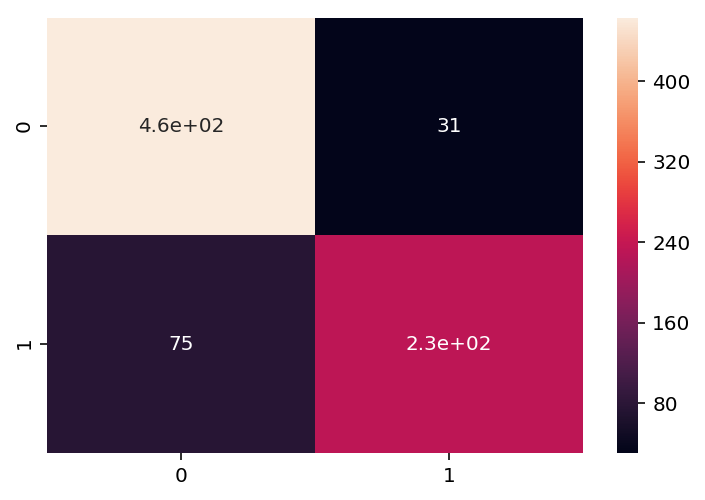

In [70]:
cm_train = confusion_matrix(y_train_fin, y_train_fin_predict)
ax = sns.heatmap(cm_train, annot=True)

In [71]:
print(classification_report(y_train_fin, y_train_fin_predict))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       494
           1       0.88      0.76      0.81       307

   micro avg       0.87      0.87      0.87       801
   macro avg       0.87      0.85      0.86       801
weighted avg       0.87      0.87      0.87       801



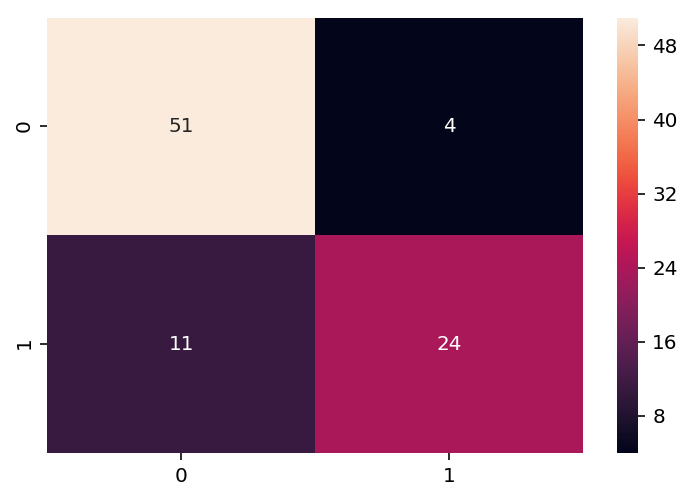

In [72]:
cm_val = confusion_matrix(y_val, y_val_predict)
ax = sns.heatmap(cm_val, annot=True)

In [73]:
print(classification_report(y_val, y_val_predict))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87        55
           1       0.86      0.69      0.76        35

   micro avg       0.83      0.83      0.83        90
   macro avg       0.84      0.81      0.82        90
weighted avg       0.84      0.83      0.83        90



In [74]:
accuracy_train = accuracy_score(y_train_fin, y_train_fin_predict)
accuracy_val = accuracy_score(y_val, y_val_predict)
print(f'Accuracy_train: {accuracy_train:.2f}')
print(f'Accuracy_val: {accuracy_val:.2f}')

Accuracy_train: 0.87
Accuracy_val: 0.83


Наиболее важные фичи

In [75]:
sorted(zip(X_train_fin.columns, grid_search_dtc.best_estimator_.feature_importances_), 
       reverse=True, key=lambda x: x[1])

[('title_Mr.', 0.41952218294365473),
 ('Fare', 0.23688533184706936),
 ('Age', 0.12999974722883698),
 ('Pclass_3', 0.10971211425801992),
 ('isMale', 0.04899014092307946),
 ('Parch', 0.01847963274429886),
 ('Pclass_2', 0.01691818881471306),
 ('Embarked_S', 0.015400166683558324),
 ('title_Mrs.', 0.0031137638668874827),
 ('SibSp', 0.0009787306898818352),
 ('Pclass_1', 0.0),
 ('Embarked_C', 0.0),
 ('Embarked_Q', 0.0),
 ('title_Dr.', 0.0),
 ('title_Master.', 0.0),
 ('title_Miss.', 0.0),
 ('title_Rev.', 0.0),
 ('title_no_title', 0.0)]

In [76]:
from sklearn.tree import export_graphviz
import graphviz

In [77]:
dot_tree = export_graphviz(model, out_file=None, filled=True, feature_names=X_train_fin.columns, 
                           class_names=None)

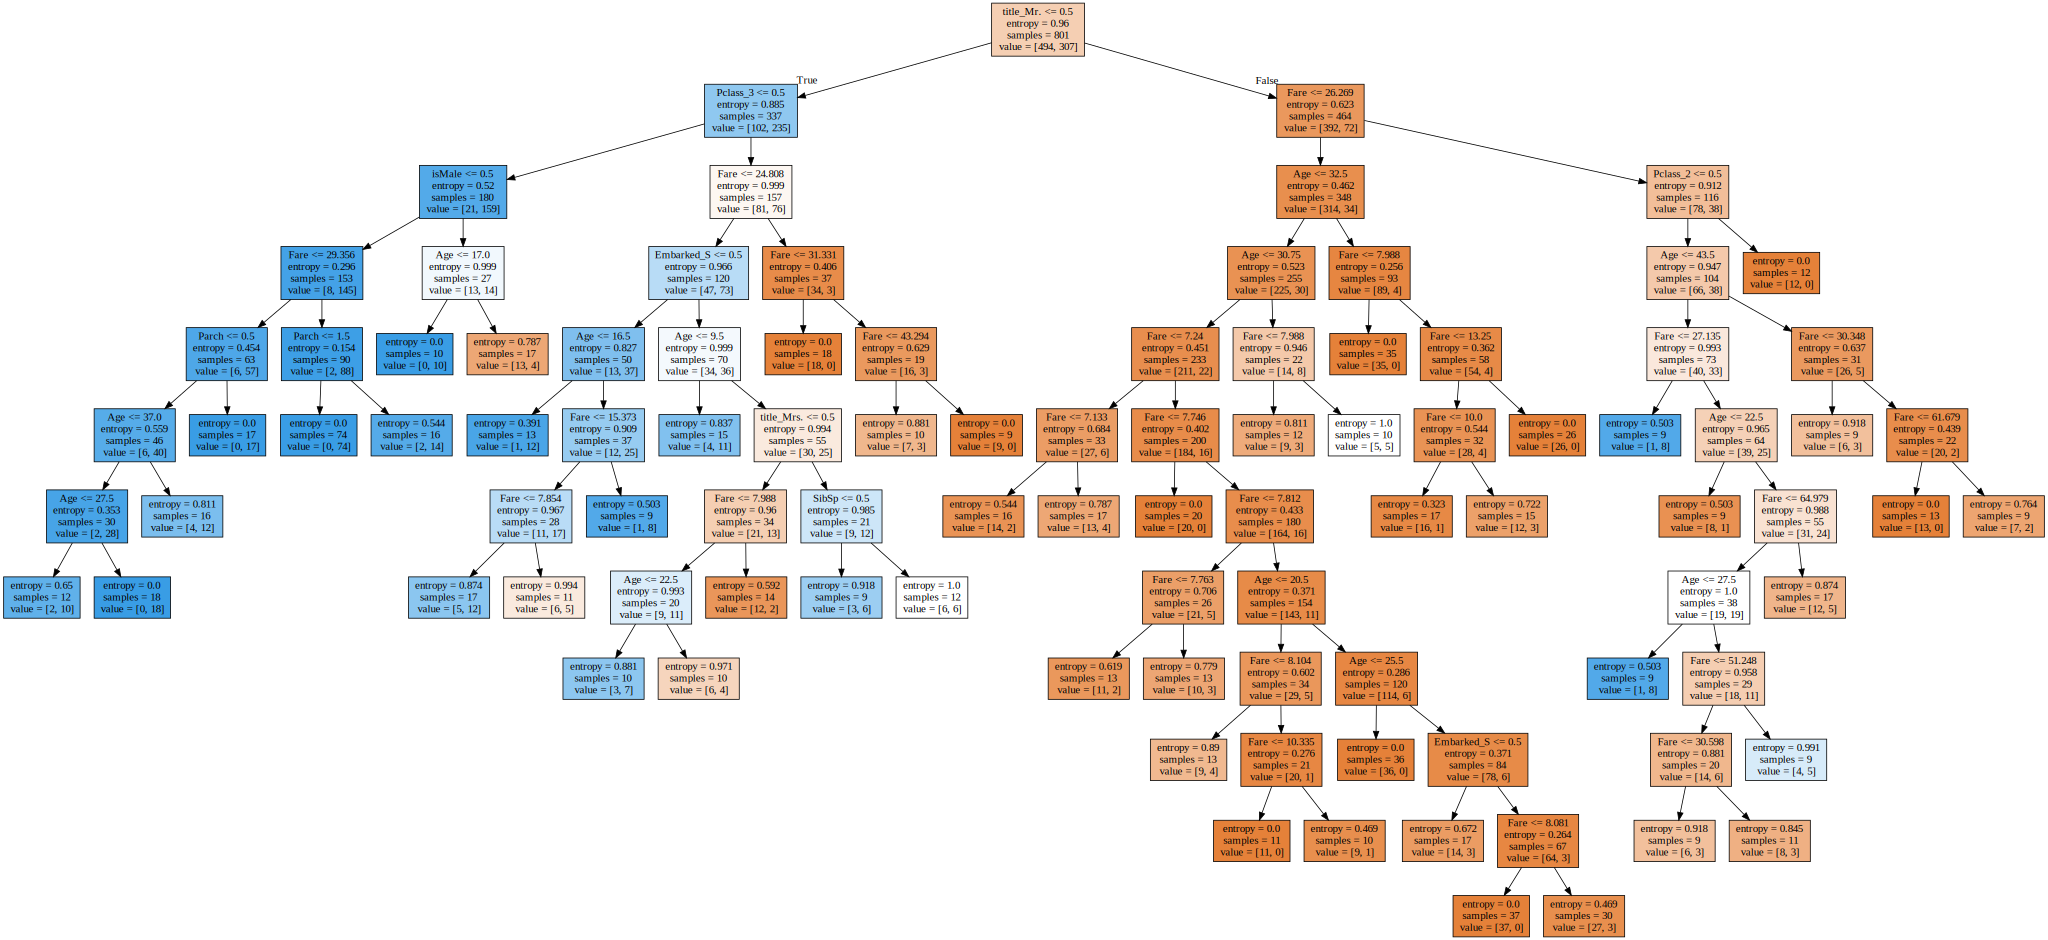

In [78]:
graph = graphviz.Source(dot_tree)
graph

In [79]:
from sklearn.metrics import roc_auc_score, roc_curve

In [80]:
roc_auc_train_fin = np.round(roc_auc_score(y_train_fin, y_train_fin_prob), 2)
roc_auc_val = np.round(roc_auc_score(y_val, y_val_prob), 2)
print("Train: ", roc_auc_train_fin)
print("Test: ", roc_auc_val)

Train:  0.94
Test:  0.84


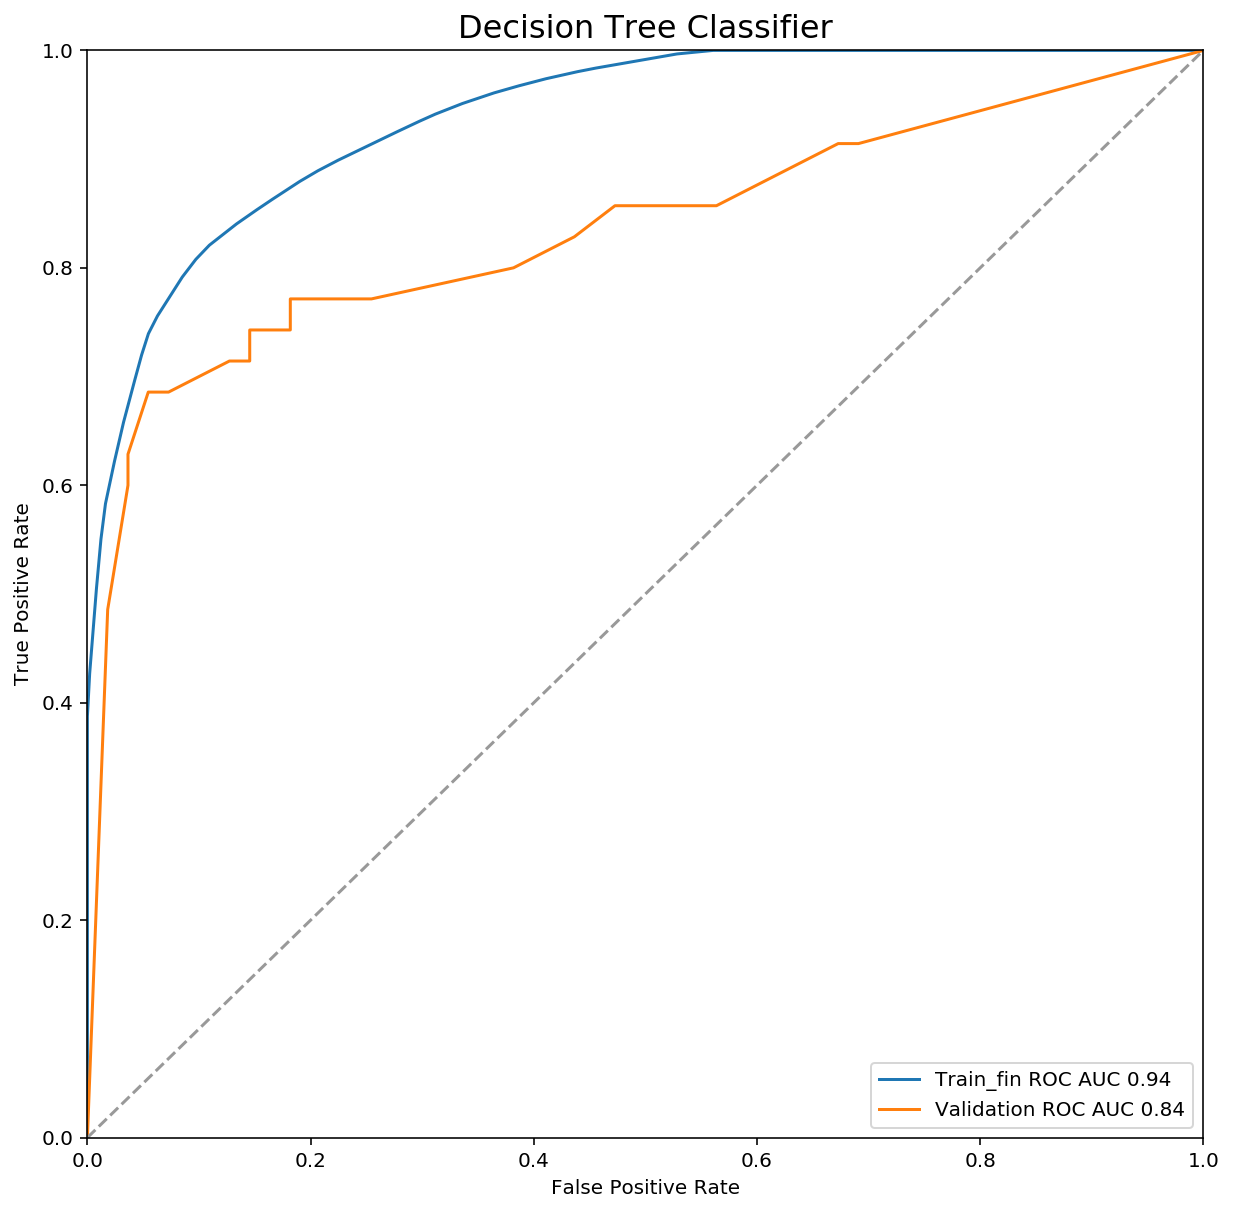

In [81]:
import matplotlib

fpr_train_fin, tpr_train_fin, thresholds_train_fin = roc_curve(y_train_fin, y_train_fin_prob)
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_prob)

matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
plt.plot(fpr_train_fin, tpr_train_fin, label='Train_fin ROC AUC {0}'.format(roc_auc_train_fin))
plt.plot(fpr_val, tpr_val, label='Validation ROC AUC {0}'.format(roc_auc_val))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

In [82]:
from sklearn.metrics import precision_recall_curve

In [83]:
precisions_val, recalls_val, thresholds_val = precision_recall_curve(y_val, y_val_prob)
precisions_train_fin, recalls_train_fin, thresholds_train_fin = precision_recall_curve(y_val, y_val_prob)

In [84]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, model='Decision Tree Classifier\n'):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Точность')
    plt.plot(thresholds, recalls[:-1], 'g--', label='Полнота')
    plt.plot([0.5, 0.5], [0, 1])
    plt.xlabel('Порог')
    plt.legend(loc='center left')
    plt.ylim([0,1])
    plt.title(f'Модель: {model}')

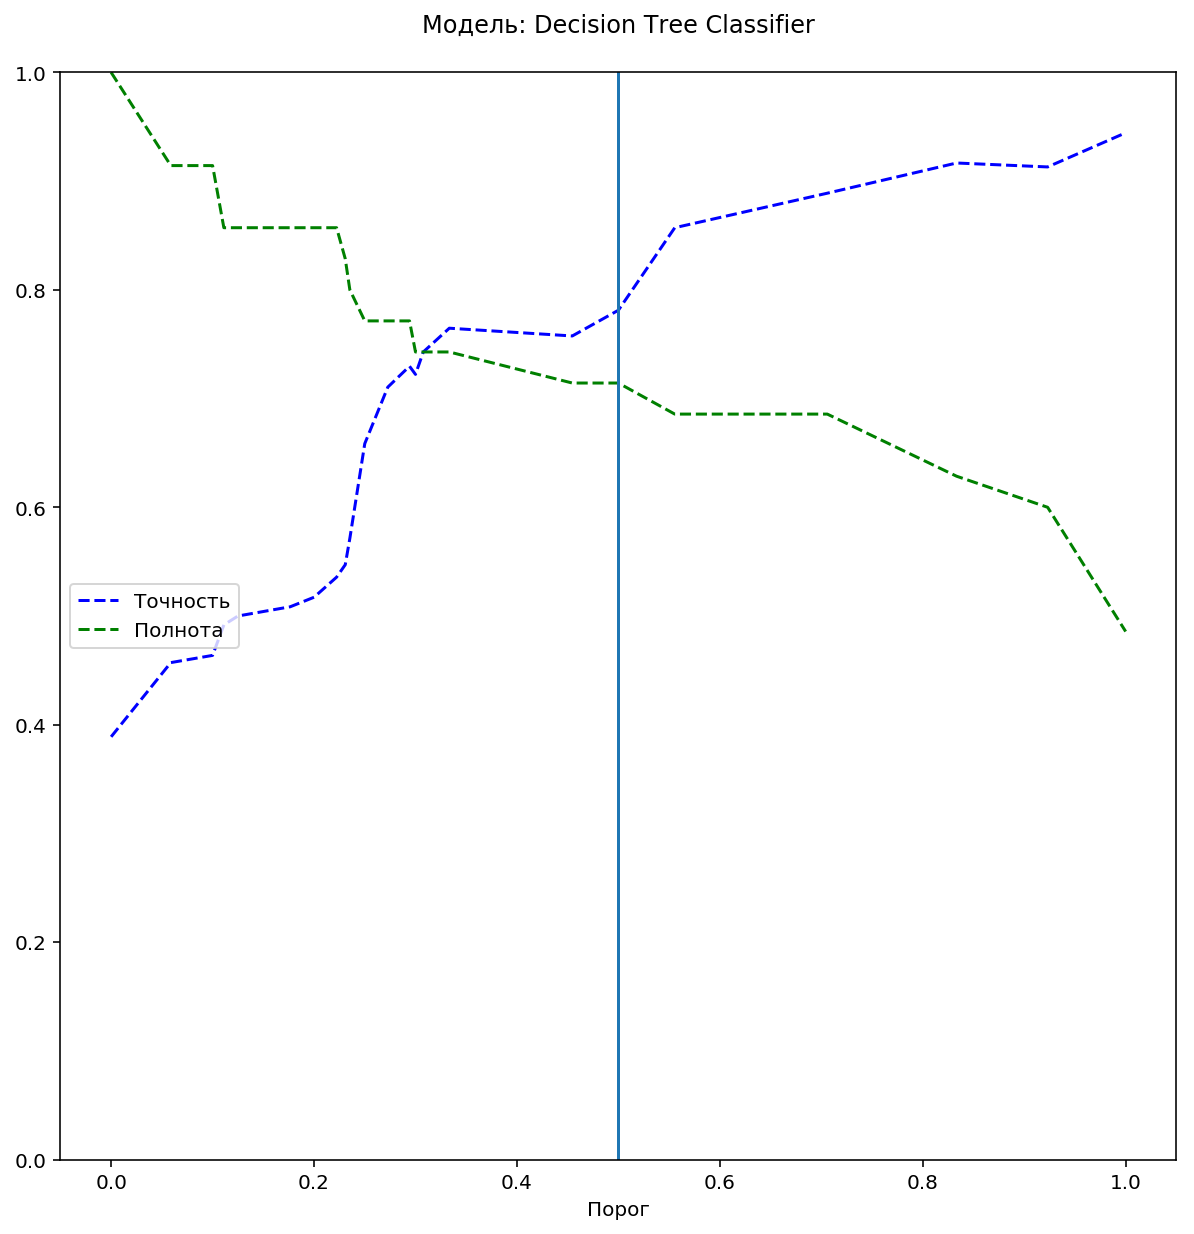

In [85]:
plot_precision_recall_vs_threshold(precisions_train_fin, recalls_train_fin, thresholds_train_fin)

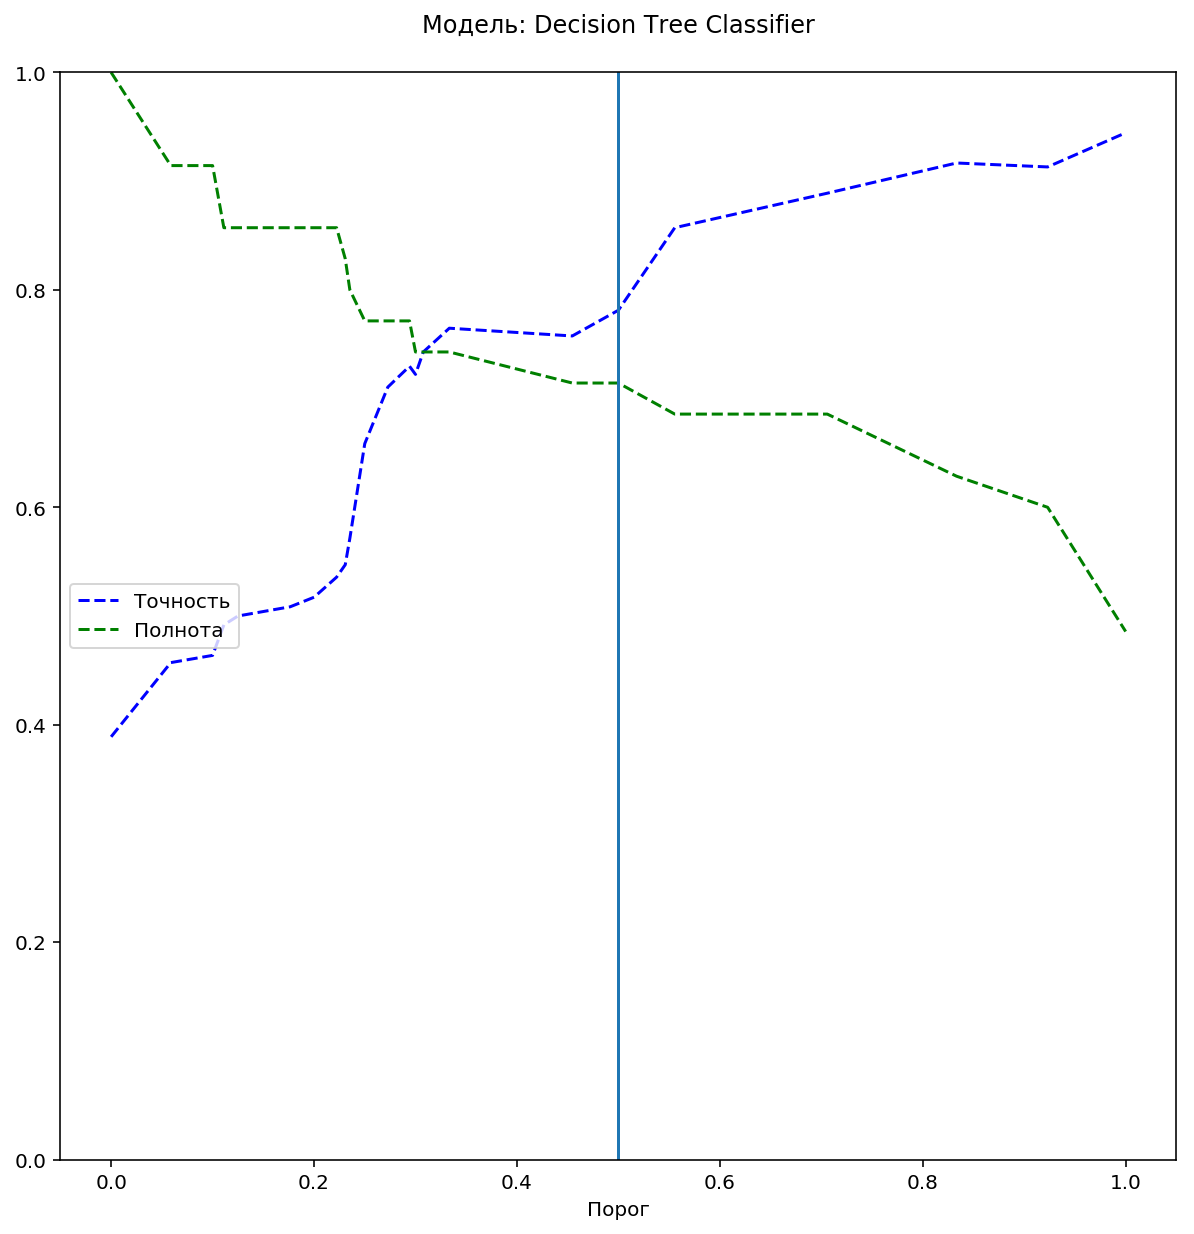

In [86]:
plot_precision_recall_vs_threshold(precisions_val, recalls_val, thresholds_val)

In [87]:
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=True, random_state=None,
            splitter='best')

In [88]:
y_test_predict = model.predict(X_test)

In [89]:
y_test_predict.shape

(418,)

In [90]:
X_test.index

Int64Index([ 892,  893,  894,  895,  896,  897,  898,  899,  900,  901,
            ...
            1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309],
           dtype='int64', name='PassengerId', length=418)

In [91]:
y_test_predict

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [92]:
submussion = pd.DataFrame({'PassengerId':X_test.index, 'Survived': y_test_predict})

In [93]:
submussion.head(10)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


In [94]:
submussion.to_csv('./submussion.csv', index=False)

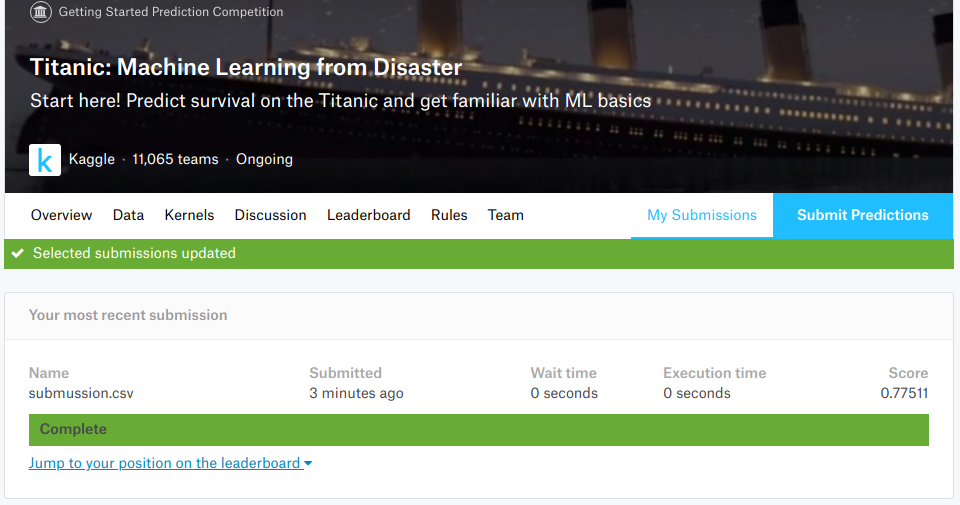

In [95]:
from IPython.display import Image
Image(filename='Screenshot_kaggle.png')